In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker

In [2]:
! radical-stack


  python               : /Users/mturilli/.virtualenvs/analytics-devel/bin/python3
  pythonpath           : 
  version              : 3.8.10
  virtualenv           : /Users/mturilli/.virtualenvs/analytics-devel

  radical.analytics    : 1.5.0-v1.5.0-5-g2ad4481@feature-ru-option
  radical.entk         : 1.5.1
  radical.gtod         : 1.5.0
  radical.pilot        : 1.6.6-v1.6.6@master
  radical.saga         : 1.5.2
  radical.utils        : 1.6.6-scalems-stable-9-g767c62e@tmp-mt



In [3]:
sexpids = {
    'rp.session.js-17-185.jetstream-cloud.org.eirrgang.018796.0001' :'gmx2019',
#     'rp.session.js-17-185.jetstream-cloud.org.eirrgang.018795.0021' :'gmx2019'
}
suds = sexpids.keys()
sdir = '../data/raw/'
sids = [sdir+s for s in suds]

In [4]:
%%capture capt

ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False)})

In [5]:
for sid in suds:
    ss[sid].update({'sid'     : ss[sid]['s'].uid,
                    'pid'     : ss[sid]['p'].list('uid'),
                    'expid'   : sexpids[sid],
                    'npilot'  : len(ss[sid]['p'].get()),
                    'lm'      : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact'   : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'ntask'   : len(ss[sid]['t'].get()),
                    'ntfail'  : len(ss[sid]['t'].timestamps(state='FAILED')),
                    'hostid'  : ss[sid]['s'].get(etype='pilot')[0].cfg['hostid'],
                    'gpu_node': ss[sid]['s'].get(etype='pilot')[0].cfg['gpus_per_node']})
    ss[sid].update({'pres'    : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus'   : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})
    ss[sid].update({'nnodes'  : int(ss[sid]['ncores']/56)})

In [6]:
%%capture capt

u_durations = {}

for sid in suds:
    u_durations[sid] = {}

for sid in suds:
    for uid in ss[sid]['t'].list('uid'):
        unit = ss[sid]['t'].get(etype='task', uid=uid)[0]
        durations = {}
        for k,v in rp.utils.TASK_DURATIONS_DEBUG.items():
            try:
                durations[k] = unit.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, uid, v))
                durations[k] = 0
        u_durations[sid].update({uid: durations})

In [7]:
%%capture capt

p_durations = {}

for sid in suds:
    p_durations[sid] = {}

for sid in suds:
    for pid in ss[sid]['p'].list('uid'):
        pilot = ss[sid]['p'].get(etype='pilot', uid=pid)[0]
        durations = {}
        for k,v in rp.utils.PILOT_DURATIONS_DEBUG.items():
            try:
                durations[k] = pilot.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, pid, v))
                durations[k] = 0
        p_durations[sid].update({pid: durations})

In [8]:
# With RP < 1.5.2, on Summit/Frontera, bootstrap_0_stop, cu_pre_start|stop are 
# not recorded. We cannot use the default durations.

for sid in suds:
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'bootstrap_0_start', ru.STATE: None   },
                                 # {ru.EVENT: 'bootstrap_0_stop', ru.STATE: None    }]),
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE    },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED  },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED}]]),
      'ttx_u': t.duration( event=[ {ru.EVENT: 'task_exec_start', ru.STATE: None       },      
                                   {ru.EVENT: 'task_exec_stop' , ru.STATE: None       } ])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_p'] - ss[sid]['ttx_u']})

In [9]:
info = []
for sid in suds:
    info.append({'session'             : sid,
                 'exp_id'              : sexpids[sid],
                 'resource'            : ss[sid]['pres'],
                 'pilot_lm'            : ss[sid]['lm'], 
                 '#pilots'             : ss[sid]['npilot'],
                 #'ps_active'          : ss[sid]['npact'],
                 '#cores'              : ss[sid]['ncores'], 
                 #'gpus'               : ss[sid]['ngpus'], 
                 '#nodes'              : ss[sid]['nnodes'], 
                 '#tasks executed'     : ss[sid]['ntask'],
                 'total exec. time (s)': ss[sid]['ttx_u'],
                 'RCT overheads (s)'   : ss[sid]['ovh_rtc']
                })

df_info = pd.DataFrame(info)
pd.set_option('display.max_colwidth', None)
df_info

,session,exp_id,resource,pilot_lm,#pilots,#cores,#nodes,#tasks executed,total exec. time (s),RCT overheads (s)
0,rp.session.js-17-185.jetstream-cloud.org.eirrgang.018796.0001,gmx2019,tacc.frontera,SRUN,1,28000,500,500,1759.0,131.710244


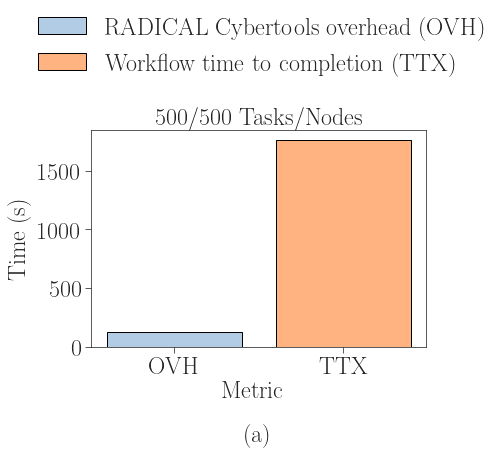

In [10]:
skip = []
nsids = len(suds) - len(skip)

fwidth = 6*nsids
fhight = 4
fig, axarr = plt.subplots(1, nsids, sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:

    if sid in skip:
        continue

    if len(suds) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['ntask'], int(ss[sid]['nnodes'])))

    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text( -0.07,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text(  0.5 , -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.35), fontsize=24, ncol=1)
    
plt.savefig('figures/ovh_ttx_500_1000.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ovh_ttx_500_1000.png', dpi=300, bbox_inches='tight')